# Hypothesis Testing

In [216]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import seaborn as sns

## Unfair coin

### simulation

In [3]:
ONE_CHANCE = 0.55
def flip_coin(sample_size:int)->list[int]:
    return np.random.choice([1, 0], sample_size, p=[ONE_CHANCE, 1-ONE_CHANCE])
flip_coin(10)

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0])

### Run testing

Text(0.5, 1.0, 'sample 30, mean 0.67')

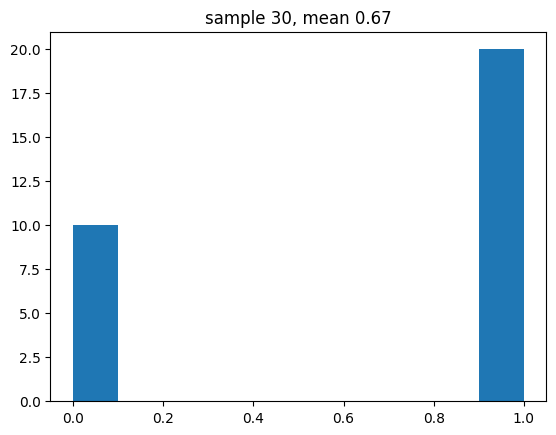

In [210]:
samples = flip_coin(30)
plt.hist(samples)
plt.title(f'sample {30}, mean {np.mean(samples):.2f}')

In [179]:
H0_VALUE = 0.5
def calculate_p_value(sample:list[bool]):
    n = len(sample)
    x_bar = np.mean(sample)
    s = np.std(sample)
    se = s / (n ** 0.5)
    z = abs(H0_VALUE - x_bar) / se
    p_value = 2 * st.norm.cdf(-z)
    confidence_interval = (x_bar - 1.96 * se, x_bar + 1.96 * se)
    return p_value, z, confidence_interval
calculate_p_value(flip_coin(30))

(0.7143930376343264,
 0.36596252735569984,
 (0.28814201332194833, 0.645191320011385))

In [180]:
def run_test(sample_size:int):
    sample = flip_coin(sample_size)
    p_value, z_score, confidence_interval = calculate_p_value(sample)
    output = {
        "sample size": sample_size,
        "p_value": p_value,
        "z score": z_score,
        "confidence interval": confidence_interval,
        "result z test": p_value > 0.05,
        "result confidence interval": confidence_interval[0] < H0_VALUE < confidence_interval[1]
    }
    return output
run_test(30)

{'sample size': 30,
 'p_value': 0.4611976834915784,
 'z score': 0.736876126183612,
 'confidence interval': (0.389341520656837, 0.7439918126764963),
 'result z test': True,
 'result confidence interval': True}

In [6]:
tmp = list()
for i in [30,100,1000]:
    test_result = run_test(i)
    tmp.append(test_result)

df = pd.DataFrame(tmp)
df['confidence interval'] = df['confidence interval'].apply(
    lambda x: (round(x[0], 3), round(x[1], 3)))

In [7]:
df

,sample size,p_value,z score,confidence interval,result z test,result confidence interval
0,30,0.714393,0.365963,"(0.355, 0.712)",True,True
1,100,0.024117,2.255254,"(0.514, 0.706)",False,False
2,1000,0.005212,2.793642,"(0.513, 0.575)",False,False


## job placement

### Read data

In [99]:
df = pd.read_csv('./job_placement.csv')
df.head()

,id,name,gender,age,degree,stream,college_name,placement_status,salary,gpa,years_of_experience
0,1,John Doe,Male,25,Bachelor's,Computer Science,Harvard University,Placed,60000,3.7,2.0
1,2,Jane Smith,Female,24,Bachelor's,Electrical Engineering,Massachusetts Institute of Technology,Placed,65000,3.6,1.0
2,3,Michael Johnson,Male,26,Bachelor's,Mechanical Engineering,Stanford University,Placed,58000,3.8,3.0
3,4,Emily Davis,Female,23,Bachelor's,Information Technology,Yale University,Not Placed,0,3.5,2.0
4,5,David Brown,Male,24,Bachelor's,Computer Science,Princeton University,Placed,62000,3.9,2.0


In [141]:
df.describe()['gpa']['std']

0.12121152504358891

In [308]:
data = []

for genre in df.placement_status.unique():
    data.append(go.Box(y=df[df.placement_status == genre].gpa, name=genre))

fig = go.Figure(data=data, layout={"title": "gpa box plot by job placement"})
iplot(fig, show_link=False)

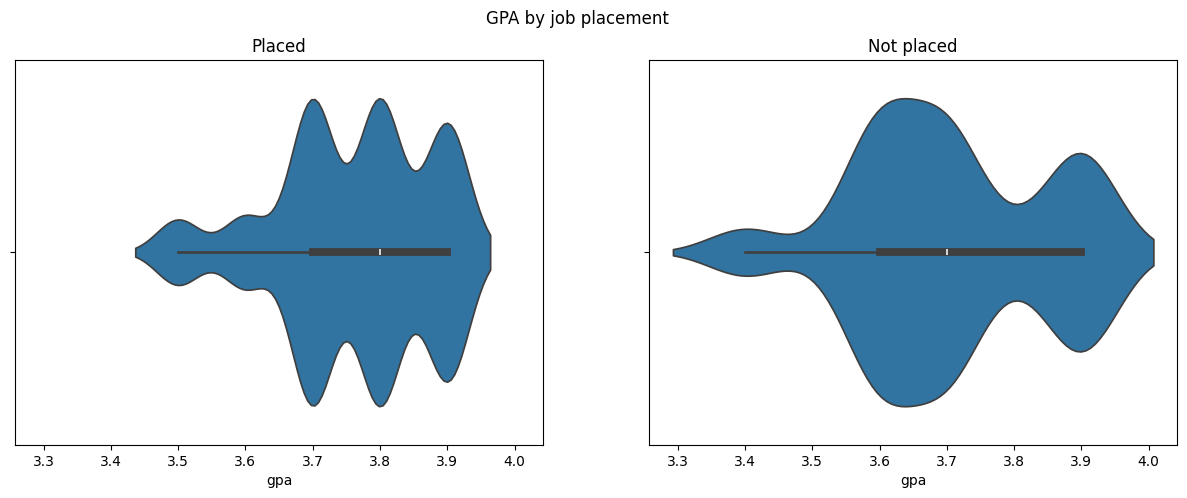

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

sns.violinplot(x=df[df['placement_status'] == 'Placed']['gpa'], ax=axes[0])
sns.violinplot(x=df[df['placement_status'] == 'Not Placed']['gpa'], ax=axes[1])

fig.suptitle('GPA by job placement')
axes[0].title.set_text('Placed')
axes[1].title.set_text('Not placed')

### t test

In [296]:
t_test_data = pd.Series()

/tmp/ipykernel_5971/1070063953.py:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [297]:
groups_statistics = df.groupby('placement_status').describe()['gpa']
groups_statistics

,count,mean,std,min,25%,50%,75%,max
placement_status,,,,,,,,
Not Placed,130.0,3.702308,0.141676,3.4,3.6,3.7,3.9,3.9
Placed,570.0,3.761404,0.113352,3.5,3.7,3.8,3.9,3.9


In [298]:
a = df.groupby('placement_status')['gpa'].var()
b = (groups_statistics['count']['Placed']-1) * a['Placed']
c = (groups_statistics['count']['Not Placed']-1) * a['Not Placed']
d = ((b+c)/(np.sum(groups_statistics['count'])-2))**0.5
groups_statistics['std']['Placed'] = d
groups_statistics['std']['Not Placed'] = d
groups_statistics

,count,mean,std,min,25%,50%,75%,max
placement_status,,,,,,,,
Not Placed,130.0,3.702308,0.119095,3.4,3.6,3.7,3.9,3.9
Placed,570.0,3.761404,0.119095,3.5,3.7,3.8,3.9,3.9


#### calculate SE & diff

In [299]:
t_test_data['SE'] = np.sum(
    [groups_statistics['std'][i] ** 2 / groups_statistics['count'][i] 
        for i in ['Not Placed', 'Placed']]) ** 0.5
t_test_data['mu_diff'] = (groups_statistics['mean']['Placed'] - groups_statistics['mean']['Not Placed'])
pd.DataFrame(t_test_data)

,0
SE,0.011575
mu_diff,0.059096


#### calculate degrees of freedom

$$
df = \frac{(n_1-1)(n_2-1)}{(n_2-1)C^2+(1-C)^2(n_1-1)}
$$
$$
C = \frac{\frac{s_1^2}{n_1}}{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}
$$

In [300]:
C = (((groups_statistics['std']['Placed'] ** 2) / groups_statistics['count']['Placed']) /
     (((groups_statistics['std']['Placed'] ** 2) / groups_statistics['count']['Placed']) +
      ((groups_statistics['std']['Not Placed'] ** 2) / groups_statistics['count']['Not Placed'])))

t_test_data['df'] = ((groups_statistics['count']['Placed'] - 1) * (groups_statistics['count']['Not Placed'] - 1) /
           (((groups_statistics['count']['Placed'] - 1) * (C**2)) +
           ((groups_statistics['count']['Not Placed'] - 1) * ((1-C)**2))))

t_test_data['df']

697.996242834021

#### run test

$$
H_0: \mu_\text{Not Place} - \mu_\text{Place} = 0\\
H_A: \mu_\text{Not Place} - \mu_\text{Place} < 0
$$

In [301]:
significance_level = 0.05
H0_DIFF = 0
HA = 'less'

In [302]:
t_test_data['score'] = (t_test_data["mu_diff"] - H0_DIFF) / t_test_data['SE']
t_test_data['score']

5.1053189564687615

In [303]:
t_test_data['p_value'] = st.t.cdf(t_test_data['score'], t_test_data['df'])
t_test_data['result'] = 'No evidence of negative impact (do not reject)'\
    if t_test_data['p_value'] > significance_level\
    else 'negative impact is confirmed (reject)'
pd.DataFrame(t_test_data)

,0
SE,0.011575
mu_diff,0.059096
df,697.996243
score,5.105319
p_value,1.0
result,No evidence of negative impact (do not reject)


In [304]:
st.ttest_ind(df[df['placement_status'] == 'Placed']['gpa'],
             df[df['placement_status'] == 'Not Placed']['gpa'],
             alternative=HA)

TtestResult(statistic=5.105318956468754, pvalue=0.9999997868177752, df=698.0)